 ## CooP - an organic, free range artisanal heritage chicken farm
 ___
 Providing improved packaging with lineage information for each individual bird.

 ### Data Schema
 ___
<details>
    
___
The Data Schema Represents chicken and egg family trees

**Chickens have:**
* Chicken ID (C_ID)
* Name (Name)
* Sex (Rooster or Hen) (Sex)
* Feather color (Color)
* Favorite song (Favorite_Song)
* Each Hen lays eggs
* Generation ID (G_ID) int

**Eggs have:** 
* An identification number (E_ID) will end up mapping to C_ID
* Location in the incubation hall where hens sit on their eggs. (IH_LOC)
* Whether that spot is near a window (as 1/3rd of the spots should be) (NW - Boolean [True, False])
* Parent IDs (PH_ID, PR_ID)(Will need to map to C_IDs)

**Chicken Genealogy:**
* The egg that it came from (E_ID)
* Its parents (PH_ID) - (PR_ID), and their eggs - (PHE_ID, PRE_ID)
* The Grandparents, etc) - HGPH_ID, HGPR_ID, RGPH_ID, RGPR_ID 
* any additional columns to the chicken and egg tables or any other way needed.
    
**Note:**
You will probably need more columns than just the above minimum information.
    </details>

### Generate data
___
<details>
Two weeks after your starting, all records were destroyed after a ransom malware attack scrambled the database filesystem. Despite the farmworkers trying to remember all the chicken's names, it's impossible to tell them apart now.

We need to recreate, (generate fake data) about all chickens currently on the farm (1000 chickens). \
*Some of whom are parents to others.*

**Generate the required 1000 records**

What can you do to make these records seem as realistic as possible? (have realistic timelines and age)
(Feel free to look up data as you need to, but tell us what you looked up?) 
 
 * Bonus: How could a government official check whether the dataset is faked or not? 
    (most chicken species have documented egg rates and age before producing egges)
 * Bonus Bonus: What can you do to cover up these checks?
    (use the published ranges with randomization over actual calendar days to make data more realistic) 
* Bonus Bonus Bonus: What can a government official check to see whether you're covering up their checks. Etc
    </details>


 ### Name tags for Guided Tours
 ___
 <details>
We Give guided tours of the farm and introduce all the chickens to visitors. 
To make this possible we print tags and attached to each chicken's leg. 

The Tag includes:

* The Chicken's name
* Their Favorite song
* Their Parents
* Their Grandparents
* The Location each parent and grand parent was incubated
* A randomly selected first cousin of the chicken
    
    https://github.com/aruljohn/popular-baby-names/blob/master/2000/boy_names_2000.csv \
    https://github.com/fivethirtyeight/data/blob/master/classic-rock/classic-rock-song-list.csv
    </details>

### Bonus
___
<details>
Create a dashboard in Metabase that shows some KPIs for this chicken farm. 
Please include either a public link or a screenshot.
    </details>

### Assumptions
<details>

#### Start Date
On March 11, 2020, the World Health Organization (WHO) declared COVID-19, the disease caused by the SARS-CoV-2, a pandemic. The announcement followed a rising sense of alarm in the preceding months over a new, potentially lethal virus that was swiftly spreading around the world.

#### Hen to Rooster Ratio
https://www.thehappychickencoop.com/whats-the-perfect-ratio-of-hens-to-roosters/

#### List of Chicken Breeds
https://www.typesofchicken.com/best-chickens-for-texas-humidity/

https://starmilling.com/poultry-chicken-breeds/#:~:text=There%20are%209%20recognized%20colors,tailed%20Buff%2C%20White%20and%20Columbian.

Breeds for Texas
Best-egg-laying breed in Texas that doesn’t have the issues with humidity, heat, and fertility yet still lays pretty well, we suggest the Mediterranean sorts:

* Ancona
* Catalana
* Egyptian Fayoumi
* Leghorn
* Hamburg

#### Ancona Details for Texas
https://www.typesofchicken.com/keeping-ancona-chickens/
    
#### Hatching Rates
https://rosehillfarm.ca/2020/04/25/incubating-chickeneggs/#:~:text=Eggs%20typically%20hatch%20at%20a,just%20a%20law%20of%20averages
    </details>

In [195]:
import pandas as pd
import datetime
from datetime import date
from calendar import Calendar, monthrange
from dateutil.rrule import rrule, DAILY
import uuid
import numpy as np
np.random.seed(1)
import random

#We will use duckdb for Metabase analyztics and visualization
import duckdb
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

import warnings
warnings.filterwarnings('ignore')

import plotly.tools as tls
import plotly.express as px
import plotly.io as pio

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [196]:
## Paramanters

start_date = '03/11/2020'
start_hen_count =45
start_rooster_count = 1

breed = 'Anacona' # Anacona is heat tolerant and good for texas
color = 'Black&White'   #They are Black with white specs
expected_egg_rate_min = 180
expected_egg_rate_max = 220

min_egg_producing_age = '20 weeks' #5 months
anacona_lifespan_min = '8 years'
anacona_lifespan_max = '12 years'


#Daily Log is the Audit Log of every day since the Farm began operation.
#Log can be used to track Month, High&Lo Temps, Humidity, Number of Sunlight Hours, 
# Number of Eggs collected, Number of Eggs hatched, total number of chickens etc.

#Create initial daily log Pandas Dataframe
dailylog_df = pd.DataFrame()

#Initial Farm Operation Investment (4 hens & 1 rooster)
int_hen_list = [['Mary', 'Hen'], ['Pat', 'Hen'], ['Barb', 'Hen'], ['Liz', 'Hen'] ]
int_rooster_list = [['Ralph', 'Rooster']]

#Location
location = [['A', 'False'],['B', 'True'],['C', 'False']]
location_df = pd.DataFrame(location, columns = ['IH_Location', 'Near_Window'])

#Time delay from purchase to production as we purchased young chicks
delay_start = '1 Month or 5 weeks'
egg_production_start = '04/15/2020'

#Create Empyt Eggs Dataframe from list
egg_columns = ['E_ID', 'PH_ID', 'PR_ID', 'IH_LOC', 'NW' ]
egg_df = pd.DataFrame(columns=['E_ID', 'PH_Name', 'PH_ID', 'PR_ID', 'IH_LOC', 'NW' ])

#Songs Table - additional attributes can be uese to plot and analyze
songs_df = pd.read_csv('Coop/songlist.csv')

hens_names = pd.read_csv('Coop/census-female-names.csv', usecols=[0], header=None)
rooster_names = pd.read_csv('Coop/boy_names_2000.csv', usecols=[1], header=None)

sex_list = ['Rooster', 'Hen']
rooster_names_list = rooster_names[1].tolist()
hen_names_list = hens_names[0].tolist()



In [197]:
#Convert Near_Window to Boolean Values
location_df['Near_Window'] = location_df['Near_Window'].map({'False':False, 'True':True})

In [198]:
#Egg Production Rates
egg_rate_min = expected_egg_rate_min / 365
egg_rate_max = expected_egg_rate_max / 365
print("min_rate/day = ", egg_rate_min, "\nmax_rate/day = ", egg_rate_max)

min_rate/day =  0.4931506849315068 
max_rate/day =  0.6027397260273972


In [199]:
#Create initial Chicken Dataframe from investment:

chicken_list = int_hen_list + int_rooster_list

df = pd.DataFrame (chicken_list, columns = ['Name', 'Sex'])
df['Color'] = 'Black&White'
#df

In [200]:
#Egg Rate Per Chicken (Rooster = 0)
#egg_rate_min egg_rate_max

#Randomly Assign Egg Rate to Hens in Base Family
rate = np.random.randint(expected_egg_rate_min, expected_egg_rate_max, size=4)
df['egg_rate_per_year'] = pd.DataFrame(rate, columns=['egg_rate'])

___

### Initial Flock
The initial investment, Flock Size consisted of 4 Hens and 1 Rooster

In [201]:
df.head(5)

,Name,Sex,Color,egg_rate_per_year
0,Mary,Hen,Black&White,217.0
1,Pat,Hen,Black&White,192.0
2,Barb,Hen,Black&White,188.0
3,Liz,Hen,Black&White,189.0
4,Ralph,Rooster,Black&White,NaN


___

#### Generate Unique IDs for each bird in the Initial Flock

In [202]:
#Map initial Family to unique Chicken_IDs
#generate the number of IDs that are needed to be applied to each bird with a unique ID
names = df['Name'].tolist()

# generte Unique ids
ids = np.random.randint(low=1e6, high=1e9, size = len(names))

# maps ids to names
maps = {k:v for k,v in zip(names, ids)}

# add new id column
df['C_ID'] = df[['Name']].agg(' '.join, 1).map(maps)

#Add Generation to Table - Initial_Flock, Gen1, Gen2, Gen3, Gen4
#The Generation column will help us track the operation growth and family, etc.
#Assign Initial_Flock to our initila flock birds
df['Generation'] = "Initial_Flock"

In [203]:
#Uncomment to show Birds with Names and IDs
df

,Name,Sex,Color,egg_rate_per_year,C_ID,Generation
0,Mary,Hen,Black&White,217.0,225766667,Initial_Flock
1,Pat,Hen,Black&White,192.0,631311759,Initial_Flock
2,Barb,Hen,Black&White,188.0,397591248,Initial_Flock
3,Liz,Hen,Black&White,189.0,630559425,Initial_Flock
4,Ralph,Rooster,Black&White,NaN,800981516,Initial_Flock


#### Generating egg generation rates and totals eggs of initial Flock

In [204]:
#Calculate end-date using today's date
end_date = date.today()
today = date.today()

In [205]:
# initializing the start and end date
start_date = date(2020, 4, 15)
end_date = date(2020, 3, 31)

In [206]:
# iterating over the dates
#for d in rrule(DAILY, dtstart=start_date, until=end_date):
 #   print(d.strftime("%Y-%m-%d"))

___
Use pandas to Iterate through a range of dates \
use the Pandas date_range() function method. It returns a fixed frequency DatetimeIndex.
Syntax: pandas.date_range(start, end)

Parameter:\
start is the starting date \
end is the ending date

#### Generate a Daily Farm Log that can be used to track daily operations

In [207]:
# specify the start date is 2021 jan 1 st
# specify the end date is 2021 feb 1 st
dailylog_df['Dates']= pd.date_range(start='04/15/2020', end=today)

In [208]:
df['diff_years'] = (dailylog_df.iloc[-1]['Dates'] - dailylog_df.iloc[0]['Dates']) / np.timedelta64(1, 'Y')
df['egg_count'] = df['egg_rate_per_year'] * df['diff_years']

In [209]:
print("The total number of Farm Operations Days to date:", dailylog_df.shape[0])

The total number of Farm Operations Days to date: 1050


This provides an expectation on the number of total eggs from the Initial Flock since the start of Farm Operations

In [210]:
df.head()

,Name,Sex,Color,egg_rate_per_year,C_ID,Generation,diff_years,egg_count
0,Mary,Hen,Black&White,217.0,225766667,Initial_Flock,2.872064,623.237986
1,Pat,Hen,Black&White,192.0,631311759,Initial_Flock,2.872064,551.436374
2,Barb,Hen,Black&White,188.0,397591248,Initial_Flock,2.872064,539.948117
3,Liz,Hen,Black&White,189.0,630559425,Initial_Flock,2.872064,542.820181
4,Ralph,Rooster,Black&White,NaN,800981516,Initial_Flock,2.872064,NaN


In [211]:
#Round Egg Count down as egg counts have to be a whole number, Int.
df['egg_count_round'] = df['egg_count'].apply(np.floor)

#Create a seperate Hens and Rooster Table for reporting and Management.
hens_df = df[df['Sex'].str.match('Hen')]
roosters_df = df[df['Sex'].str.match('Rooster')]

#Convert the egg_count from Floats to Integers
hens_df['egg_count_round'] = hens_df['egg_count_round'].astype(int)

In [212]:
#Generate the toal Egg expectancy from the Initial Flock which will be used to generate the Eggs Table.
print("We expect the initial Flock has produced the following number of Eggs by this time:")
hens_df['egg_count_round'].sum()

We expect the initial Flock has produced the following number of Eggs by this time:


2255

In [213]:
#Uncommend to show the current Hens Table.
#hens_df

In [214]:
print("The current Egg Table contains the following Columns:")
egg_df.columns

The current Egg Table contains the following Columns:


Index(['E_ID', 'PH_Name', 'PH_ID', 'PR_ID', 'IH_LOC', 'NW'], dtype='object')

In [215]:
print("The current Location Table contains the following Columns:")
location_df.columns

The current Location Table contains the following Columns:


Index(['IH_Location', 'Near_Window'], dtype='object')

In [216]:
#Uncomment to show the current Rooster Table:
#roosters_df

___

### Generate First Generation Eggs

In [217]:
print("Looping through each Hen and their associated egg counts per Hen to generate the Egg Table")
#eggs_df = pd.DataFrame()

#convert location table to a list to radomonly assign egg location - egg can only have 1 of three locations based on assumptions.
location_list = location_df['IH_Location'].tolist()
number_of_samples = 1
NW = 'False'

#Convert Rooster table to List to radomon aassign Rooster to Egg:
rooster_list = roosters_df['C_ID'].tolist()

for index, row in hens_df.iterrows():
    eggs_per_hen = row['egg_count_round']
    hen = row['Name']
    PH_ID = row['C_ID']
    #print(row['egg_count_round'])
    print( row['Name'], eggs_per_hen)
    
    for i in range(eggs_per_hen):
        #Create a new random Egg ID - E_ID
        # generte random integer ids
        # generate egg id
        E_ID = np.random.randint(low=1e3, high=1e9)
        #generate Parent Rooster ID - PR_ID
        PR_ID = random.choices(population=rooster_list, k=number_of_samples)
        
        #Generate Location and assign to each egg
        IH_LOC = random.choices(population=location_list, k=number_of_samples)
                        
        #Append each egg to the Egg Table:
        egg_df = egg_df.append(pd.DataFrame({'E_ID': E_ID, 'PH_Name': hen, 'PH_ID': PH_ID, 'PR_ID': PR_ID, 'IH_LOC': IH_LOC, 'NW': NW}, index=[0]), ignore_index=True)

Looping through each Hen and their associated egg counts per Hen to generate the Egg Table
Mary 623
Pat 551
Barb 539
Liz 542


In [218]:
#Add Parent_Gen Column to the Egg Table: The initial entry will be Initial_Flock, Gen1, Gen2, Gen3, Gen4
#The Parent_Gen column will help track the operation growth and family, etc.
#Assign Initial_Flock to our initila flock birds
egg_df['Parent_Gen'] = "Initial_Flock"

In [219]:
print("The Inital Flock has generated", egg_df.shape[0] ,"total eggs and added to the Egg Table")

The Inital Flock has generated 2255 total eggs and added to the Egg Table


In [220]:
print("The total number of unique Egg IDs:", egg_df['E_ID'].nunique())

The total number of unique Egg IDs: 2255


In [221]:
egg_df.head(2)

,E_ID,PH_Name,PH_ID,PR_ID,IH_LOC,NW,Parent_Gen
0,592323119,Mary,225766667,800981516,C,False,Initial_Flock
1,410431189,Mary,225766667,800981516,A,False,Initial_Flock


In [263]:
#Check for duplicate IDs
egg_df[egg_df.duplicated(['E_ID'], keep=False)]

,E_ID,PH_Name,PH_ID,PR_ID,IH_LOC,NW,Parent_Gen


In [222]:
#Set Location values for Window Location based on IH_LOC == B
egg_df.loc[(egg_df['IH_LOC'] == 'B'), 'NW'] = True 

In [223]:
ev_df = egg_df['PH_Name'].value_counts().rename_axis('Hen').reset_index(name='egg_count')
ev_df

,Hen,egg_count
0,Mary,623
1,Pat,551
2,Liz,542
3,Barb,539


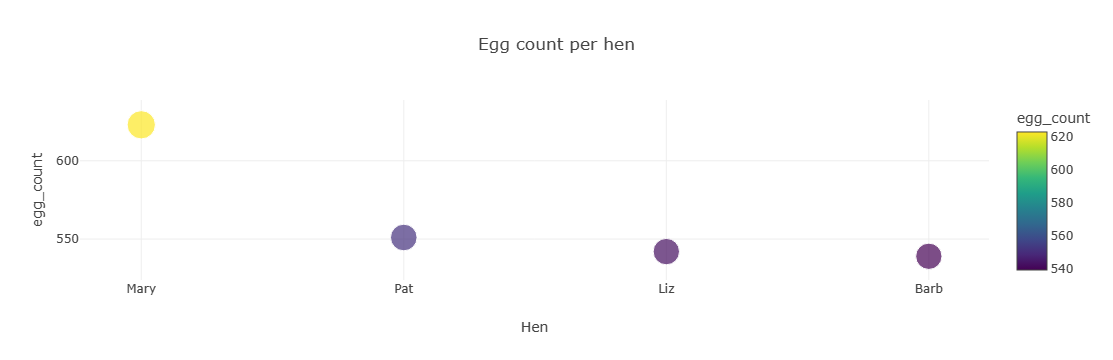

In [224]:
#Plot Sensor Execution Counts per hour
fig = px.scatter(ev_df, x='Hen', y='egg_count', 
              template = 'none',
              color = 'egg_count',
              size = 'egg_count',
            title=f"Egg count per hen")
pio.write_html(fig,  f'totaleggs.html')
fig.show()

In [225]:
df.columns

Index(['Name', 'Sex', 'Color', 'egg_rate_per_year', 'C_ID', 'Generation',
       'diff_years', 'egg_count', 'egg_count_round'],
      dtype='object')

In [226]:
# Initial Flock Chickens Table
chickens_df = df[['Name', 'Sex', 'Color', 'C_ID', 'Generation']]
#Assign NaN values to First Generation Chickens for E_ID, PH_Name, PH_ID, PR_ID


### Assign Favorite Songs to Initial Flock Chickens

In [227]:
songs_df.head(5)

,Song Clean,ARTIST CLEAN,Release Year,COMBINED,First?,Year?,PlayCount,F*G
0,Caught Up in You,.38 Special,1982,Caught Up in You by .38 Special,1,1,82,82
1,Fantasy Girl,.38 Special,NaN,Fantasy Girl by .38 Special,1,0,3,0
2,Hold On Loosely,.38 Special,1981,Hold On Loosely by .38 Special,1,1,85,85
3,Rockin' Into the Night,.38 Special,1980,Rockin' Into the Night by .38 Special,1,1,18,18
4,Art For Arts Sake,10cc,1975,Art For Arts Sake by 10cc,1,1,1,1


In [228]:
#Create Song list and assign to Chickens
Generation = "Initial_Flock"
song_list = songs_df['Song Clean'].to_list()
chickens_df["Favorite_Song"] = np.random.choice(song_list, size=len(chickens_df))
#chickens_df['Genration'] = Generation

In [229]:
chickens_df

,Name,Sex,Color,C_ID,Generation,Favorite_Song
0,Mary,Hen,Black&White,225766667,Initial_Flock,Paradise By The Dashboard Light
1,Pat,Hen,Black&White,631311759,Initial_Flock,With a Little Luck
2,Barb,Hen,Black&White,397591248,Initial_Flock,Walk On The Wild Side
3,Liz,Hen,Black&White,630559425,Initial_Flock,Wild Horses
4,Ralph,Rooster,Black&White,800981516,Initial_Flock,Pride of Man


In [262]:
#Check for duplicate IDs
chickens_df[chickens_df.duplicated(['C_ID'], keep=False)]

,Name,Sex,Color,C_ID,Generation,Favorite_Song


___

### Convert Initial Flock Eggs to Gen 1 Chickens


In [230]:
eggconversion_ratio = 0.25

In [231]:
hens_df

,Name,Sex,Color,egg_rate_per_year,C_ID,Generation,diff_years,egg_count,egg_count_round
0,Mary,Hen,Black&White,217.0,225766667,Initial_Flock,2.872064,623.237986,623
1,Pat,Hen,Black&White,192.0,631311759,Initial_Flock,2.872064,551.436374,551
2,Barb,Hen,Black&White,188.0,397591248,Initial_Flock,2.872064,539.948117,539
3,Liz,Hen,Black&White,189.0,630559425,Initial_Flock,2.872064,542.820181,542


In [232]:
#Calculate Selection Rate to hatch per Hen
first_window = 30 * 6 * 0.4
#time = 6 months or egg_rate_per_year / 2

In [626]:
first_gen_selection = hens_df[['Name', 'Sex', 'egg_rate_per_year', 'C_ID', 'Generation']]
first_gen_selection['Counts'] = (first_gen_selection['egg_rate_per_year'] / 2 * 0.37).apply(np.floor)
#df['egg_count_round'] = df['egg_count'].apply(np.floor)

In [627]:
first_gen_selection

,Name,Sex,egg_rate_per_year,C_ID,Generation,Counts
0,Mary,Hen,217.0,225766667,Initial_Flock,40.0
1,Pat,Hen,192.0,631311759,Initial_Flock,35.0
2,Barb,Hen,188.0,397591248,Initial_Flock,34.0
3,Liz,Hen,189.0,630559425,Initial_Flock,34.0


In [628]:
#Select Eggs from Hens - 53% hens - 47% Roosters

In [629]:
first_gen_slicer = first_gen_selection[['Name', 'C_ID', 'Counts']]
first_gen_slicer['Counts'] = first_gen_slicer['Counts'].astype(int)

In [630]:
egg_df.columns

Index(['E_ID', 'PH_Name', 'PH_ID', 'PR_ID', 'IH_LOC', 'NW', 'Parent_Gen'], dtype='object')

In [631]:
chicken_first = pd.DataFrame()
for index, row in first_gen_slicer.iterrows():
    chicks_per_hen = row['Counts']
    hen = row['Name']
    PH_ID = row['C_ID']
    
    print( row['Name'], chicks_per_hen)
    
    # Creating a second dataframe that will be the subset of main dataframe
    #print("Second data frame")
    dataframe_first = egg_df[['E_ID', 'PH_Name', 'PH_ID', 'PR_ID']].sample(n=chicks_per_hen)
    chicken_first = chicken_first.append(dataframe_first)
    chicken_first['Generation'] = 'Gen1'
    chicken_first['Color'] = color
    chicken_first['C_ID'] = chicken_first['E_ID']
    

Mary 40
Pat 35
Barb 34
Liz 34


In [632]:
#chicken_first

In [633]:
#Assign Favorite Song to First Gen Chickens
chicken_first["Favorite_Song"] = np.random.choice(song_list, size=len(chicken_first))

#Assign Sex to First Gen Chickents
chicken_first['Sex'] = np.random.choice(sex_list, size=len(chicken_first))

first_gen_rooster_count = chicken_first[chicken_first['Sex'] == "Rooster"].shape[0]
first_gen_rooster = chicken_first[chicken_first['Sex'] == "Rooster"]

first_gen_hen_count = chicken_first[chicken_first['Sex'] == "Hen"].shape[0]
first_gen_hen = chicken_first[chicken_first['Sex'] == "Hen"]

print("The first Geration has produced:")
print("================================")
print(first_gen_rooster_count, "Roosters")
print(first_gen_hen_count, "Hens")

#Gerate the an appropriate nummber of Rooster Names for Fist Generation and assign
first_gen_rooster_names = random.sample(rooster_names_list, first_gen_rooster_count)
first_gen_rooster['Name'] = np.random.choice(rooster_names_list, size=len(first_gen_rooster))

#Generate the appropriate number/list of Hens Names for First Generation and assign
first_gen_hens_names = random.sample(hen_names_list, first_gen_hen_count)
first_gen_hen['Name'] = np.random.choice(hen_names_list, size=len(first_gen_hen))


first_gen_chickens = pd.concat([first_gen_hen, first_gen_rooster], axis=0)

The first Geration has produced:
69 Roosters
74 Hens


In [634]:
first_gen_chickens.head(5)

,E_ID,PH_Name,PH_ID,PR_ID,Generation,Color,C_ID,Favorite_Song,Sex,Name
1931,169163902,Liz,630559425,800981516,Gen1,Black&White,169163902,Jeremy,Hen,LORRINE
1615,429368417,Barb,397591248,800981516,Gen1,Black&White,429368417,Ticket to Ride,Hen,DOROTHA
1051,802336212,Pat,631311759,800981516,Gen1,Black&White,802336212,Sex and Candy,Hen,EBONY
2229,3703835,Liz,630559425,800981516,Gen1,Black&White,3703835,South California Purples,Hen,KARIMA
1535,826181444,Barb,397591248,800981516,Gen1,Black&White,826181444,Feelin' Alright,Hen,ANNABELLE


### Combine Initial Flock and Gen 1 Tables for Chickens, Hens and Roosters

In [635]:
chickens_df.columns
chickens_df

,Name,Sex,Color,C_ID,Generation,Favorite_Song
0,Mary,Hen,Black&White,225766667,Initial_Flock,Paradise By The Dashboard Light
1,Pat,Hen,Black&White,631311759,Initial_Flock,With a Little Luck
2,Barb,Hen,Black&White,397591248,Initial_Flock,Walk On The Wild Side
3,Liz,Hen,Black&White,630559425,Initial_Flock,Wild Horses
4,Ralph,Rooster,Black&White,800981516,Initial_Flock,Pride of Man


In [636]:
#Check for duplicate IDs
chickens_df[chickens_df.duplicated(['C_ID'], keep=False)]

,Name,Sex,Color,C_ID,Generation,Favorite_Song


In [637]:
#Reorder first_gen_chickens dataframe columns to match Initial Flock Table Format so we can Concatenate them

In [638]:
chickens_df.columns

Index(['Name', 'Sex', 'Color', 'C_ID', 'Generation', 'Favorite_Song'], dtype='object')

In [639]:
#Copy original chickens_df dataframe to initial_flock_chickens for record keeping
initial_flock_chickens = chickens_df
initial_flock_eggs = egg_df

In [640]:
first_gen_chickens.columns

Index(['E_ID', 'PH_Name', 'PH_ID', 'PR_ID', 'Generation', 'Color', 'C_ID',
       'Favorite_Song', 'Sex', 'Name'],
      dtype='object')

In [641]:
first_gen_chickens = first_gen_chickens[['Name', 'Sex', 'Color', 'C_ID', 'Generation', 'Favorite_Song', 'E_ID',
       'PH_Name', 'PH_ID', 'PR_ID']]

In [642]:
#first_gen_chickens

In [643]:
#Combine Initial Flock Chickens and First Gen Chickens into Chickens Table
chickens_combined_df = pd.concat([chickens_df, first_gen_chickens], axis=0 )

In [644]:
chickens_combined_df.head(9)

,Name,Sex,Color,C_ID,Generation,Favorite_Song,E_ID,PH_Name,PH_ID,PR_ID
0,Mary,Hen,Black&White,225766667,Initial_Flock,Paradise By The Dashboard Light,NaN,NaN,NaN,NaN
1,Pat,Hen,Black&White,631311759,Initial_Flock,With a Little Luck,NaN,NaN,NaN,NaN
2,Barb,Hen,Black&White,397591248,Initial_Flock,Walk On The Wild Side,NaN,NaN,NaN,NaN
3,Liz,Hen,Black&White,630559425,Initial_Flock,Wild Horses,NaN,NaN,NaN,NaN
4,Ralph,Rooster,Black&White,800981516,Initial_Flock,Pride of Man,NaN,NaN,NaN,NaN
1931,LORRINE,Hen,Black&White,169163902,Gen1,Jeremy,169163902,Liz,630559425,800981516
1615,DOROTHA,Hen,Black&White,429368417,Gen1,Ticket to Ride,429368417,Barb,397591248,800981516
1051,EBONY,Hen,Black&White,802336212,Gen1,Sex and Candy,802336212,Pat,631311759,800981516
2229,KARIMA,Hen,Black&White,3703835,Gen1,South California Purples,3703835,Liz,630559425,800981516


In [645]:
print("The initial Flock Hens generated", egg_df.shape[0], "eggs and", first_gen_chickens.shape[0], "chickens")

The initial Flock Hens generated 2255 eggs and 143 chickens


In [646]:
chickens_df['C_ID'].nunique()

5

In [647]:
#Check for duplicate IDs
chickens_df[chickens_df.duplicated(['C_ID'], keep=False)]

,Name,Sex,Color,C_ID,Generation,Favorite_Song


In [648]:
chickens_df.to_csv('Coop/gen_one_flock_df.csv')

___

## Gen 1 Hens to Generate Eggs for Gen 2 Chicks

#### List and Count for Hens from Gen 1

In [649]:
#Assign Egg Rates to Hens from Gen 1
#Randomly Assign Egg Rate to Hens in Base Family
rate1 = np.random.randint(expected_egg_rate_min, expected_egg_rate_max, size=first_gen_hen_count)

first_gen_hen['egg_rate_per_year'] = np.random.choice(rate1, size=len(first_gen_hen))

In [650]:
#first_gen_hen.head(5)

In [651]:
#Create initial eggloggen1_df daily log Pandas Dataframe

eggloggen1_df = pd.DataFrame()
eggloggen1_df['Dates']= pd.date_range(start='10/15/2020', end=today)

eggloggen1_df['diff_years'] = (eggloggen1_df.iloc[-1]['Dates'] - eggloggen1_df.iloc[0]['Dates']) / np.timedelta64(1, 'Y')
gen1_diff_years = (eggloggen1_df.iloc[-1]['Dates'] - eggloggen1_df.iloc[0]['Dates']) / np.timedelta64(1, 'Y')
first_gen_hen['egg_count'] = first_gen_hen['egg_rate_per_year'] * gen1_diff_years

#Round Egg Count down as egg counts have to be a whole number, Int.
first_gen_hen['egg_count_round'] = first_gen_hen['egg_count'].apply(np.floor)

#Convert the egg_count from Floats to Integers
first_gen_hen['egg_count_round'] = first_gen_hen['egg_count_round'].astype(int)

In [652]:
print("The total number of Farm Operations Days to date for Gen 1 Hens:", eggloggen1_df.shape[0])

The total number of Farm Operations Days to date for Gen 1 Hens: 867


In [653]:
#The roosters could be from the Original Flock (1) or the  Gen1 Roosters
roosters_df = chickens_combined_df[chickens_combined_df.Sex == 'Rooster']

In [654]:
#The Hens for laying Gen 2 eggs would only include the Gen 1 Hens - first_gen_hen
#first_gen_hen.head(10)
first_gen_hen.columns

Index(['E_ID', 'PH_Name', 'PH_ID', 'PR_ID', 'Generation', 'Color', 'C_ID',
       'Favorite_Song', 'Sex', 'Name', 'egg_rate_per_year', 'egg_count',
       'egg_count_round'],
      dtype='object')

In [655]:
print("The number of potentail Roosters for Gen 2 is:", roosters_df.shape[0])

The number of potentail Roosters for Gen 2 is: 70


#### Eggs

In [656]:
print("Looping through each Hen and their associated egg counts per Hen to generate the Egg Table")
#Second Generation of Eggs
eggs2_df = pd.DataFrame()

#Add Parent_Gen Column to the Egg Table: The is Gen1 generating Gen2 eggs
#The Parent_Gen column will help track the operation growth and family, etc.
#Assign Gen1 to the Gen 2 Egg routine
eggs2_df['Parent_Gen'] = "Gen1"

#convert location table to a list to radomonly assign egg location - egg can only have 1 of three locations based on assumptions.
location_list = location_df['IH_Location'].tolist()
number_of_samples = 1
NW = 'False'

#Convert Complete Rooster table to List to radomon aassign Rooster to Egg:
#Use Complete Rooster List
rooster_list = roosters_df['C_ID'].tolist()

#Iterate over each Gen1 Hen

for index, row in first_gen_hen.iterrows():
    eggs_per_hen = row['egg_count_round']
    hen = row['Name']
    PH_ID = row['C_ID']
    #print(row['egg_count_round'])
    print( row['Name'], eggs_per_hen)
    
    for i in range(eggs_per_hen):
        #Create a new random Egg ID - E_ID
        # generte random integer ids
        # generate egg id
        E_ID = np.random.randint(low=1e3, high=1e9)
        Parent_Gen = "Gen1"
        #generate Parent Rooster ID - PR_ID
        PR_ID = random.choices(population=rooster_list, k=number_of_samples)
        
        #Generate Location and assign to each egg
        IH_LOC = random.choices(population=location_list, k=number_of_samples)
                        
        #Append each egg to the Egg Table:
        eggs2_df = eggs2_df.append(pd.DataFrame({'E_ID': E_ID, 'PH_Name': hen, 'PH_ID': PH_ID, 'PR_ID': PR_ID, 'IH_LOC': IH_LOC, 'NW': NW, 'Parent_Gen': Parent_Gen }, index=[0]), ignore_index=True)

Looping through each Hen and their associated egg counts per Hen to generate the Egg Table
LORRINE 481
DOROTHA 490
EBONY 474
KARIMA 476
ANNABELLE 478
TRUDIE 476
DONELLA 448
ELIZA 497
RAYMONDE 478
PORSHA 467
KAYLENE 495
MITSUKO 488
WEI 464
VALENCIA 486
LEIDA 450
SUSANN 509
LISBETH 495
JOEL 476
SIGRID 464
CAREN 495
LAUREEN 467
WINDY 505
KERI 445
DEEDRA 448
PALMIRA 464
DANELLE 471
MARVA 471
HANNELORE 483
ONITA 426
PHILOMENA 486
DONALD 443
DEE 505
BRUNA 471
LATRINA 500
GREGORY 459
ALEXA 488
CHER 452
LORELEI 505
CHARLOTT 474
ALENA 448
CHARLIE 459
CHANG 488
CHERISH 481
KIYOKO 495
URSULA 443
ASIA 429
ERMA 459
AMEE 514
KATELYN 490
CLARITA 483
DEANDREA 514
DELPHA 471
KORTNEY 448
TRICIA 476
LYNDSEY 476
ALAINE 486
LINN 443
THORA 505
CLAIRE 474
MAI 495
ALTHEA 474
TIESHA 469
GEORGANN 488
NAKISHA 452
ANGELE 448
DAYSI 514
KENNA 483
ALAINE 462
LESIA 490
DIANNE 481
DEANN 490
MELVA 448
MICHA 471
TWANDA 483


In [657]:
eggs2_df.head(3)

,Parent_Gen,E_ID,PH_Name,PH_ID,PR_ID,IH_LOC,NW
0,Gen1,705646701.0,LORRINE,169163902.0,281222266.0,C,False
1,Gen1,923493233.0,LORRINE,169163902.0,513622141.0,C,False
2,Gen1,770555209.0,LORRINE,169163902.0,800981516.0,C,False


In [658]:
eggs2_df.shape[0]

35180

In [659]:
#Check for duplicate IDs
eggs2_df[eggs2_df.duplicated(['E_ID'], keep=False)]

,Parent_Gen,E_ID,PH_Name,PH_ID,PR_ID,IH_LOC,NW


In [660]:
#Set Location values for Window Location based on IH_LOC == B
eggs2_df.loc[(eggs2_df['IH_LOC'] == 'B'), 'NW'] = True 

In [661]:
#eggs2_df.head(10)

### Convert Gen 2 Eggs to Chickens and Combine
* combine Total Eggs Table
* combine Total Chicken Table

In [662]:
#Provide a smaller rate than the first generation
gen2_eggconversion_ratio = 0.43

In [663]:
second_gen_selection = first_gen_hen[['Name', 'Sex', 'egg_rate_per_year', 'C_ID', 'Generation']]
second_gen_selection['Counts'] = (second_gen_selection['egg_rate_per_year'] / 2 * 0.23).apply(np.floor)

second_gen_selection['Counts'] = second_gen_selection['Counts'].astype(int)
#df['egg_count_round'] = df['egg_count'].apply(np.floor)
print("This selection ratio should provide the farm with", second_gen_selection['Counts'].sum(), "Gen 2 Chickens")

This selection ratio should provide the farm with 1670 Gen 2 Chickens


In [664]:
#second_gen_selection

In [665]:
second_gen_slicer = second_gen_selection[['Name', 'C_ID', 'Counts']]

In [666]:
#second_gen_slicer

In [667]:
#Check for duplicate IDs
eggs2_df[eggs2_df.duplicated(['E_ID'], keep=False)]

,Parent_Gen,E_ID,PH_Name,PH_ID,PR_ID,IH_LOC,NW


In [668]:
chicken_second = pd.DataFrame()

for index, row in second_gen_slicer.iterrows():
    chicks_per_hen = row['Counts']
    hen = row['Name']
    PH_ID = row['C_ID']
    
    
    # Creating a second dataframe that will be the subset of main dataframe
    #print("Second data frame")
    dataframe_second = eggs2_df[['E_ID', 'PH_Name', 'PH_ID', 'PR_ID']].sample(n=chicks_per_hen, replace= False)
    
    #Line to fix loop - Convert Egg ID (E_ID) to Chicken ID before appending to second generation dataframe
    dataframe_second['C_ID'] =dataframe_second['E_ID']
    
    chicken_second = chicken_second.append(dataframe_second)
    chicken_second['Generation'] = 'Gen2'
    chicken_second['Color'] = color
    
    #chicken_second['C_ID'] = chicken_second['E_ID']
    

In [669]:
chicken_second.columns

Index(['E_ID', 'PH_Name', 'PH_ID', 'PR_ID', 'C_ID', 'Generation', 'Color'], dtype='object')

In [670]:
#Check for duplicate IDs
chicken_second[chicken_second.duplicated(['E_ID'], keep=False)].sort_values("E_ID")

,E_ID,PH_Name,PH_ID,PR_ID,C_ID,Generation,Color
1677,95412191.0,KARIMA,3703835.0,275508229.0,95412191.0,Gen2,Black&White
1677,95412191.0,KARIMA,3703835.0,275508229.0,95412191.0,Gen2,Black&White
26564,189928254.0,ALAINE,76709333.0,899766072.0,189928254.0,Gen2,Black&White
26564,189928254.0,ALAINE,76709333.0,899766072.0,189928254.0,Gen2,Black&White
11943,212279309.0,DANELLE,24517643.0,170209024.0,212279309.0,Gen2,Black&White
...,...,...,...,...,...,...,...
2821,846735066.0,TRUDIE,656829586.0,574340276.0,846735066.0,Gen2,Black&White
25839,901467976.0,LYNDSEY,236336642.0,858496373.0,901467976.0,Gen2,Black&White
25839,901467976.0,LYNDSEY,236336642.0,858496373.0,901467976.0,Gen2,Black&White
5513,901773248.0,MITSUKO,413557007.0,915956610.0,901773248.0,Gen2,Black&White


In [671]:
chicken_second['C_ID'].nunique()

1635

In [672]:
chicken_second.shape[0]

1670

In [673]:
#Check for duplicate IDs
#chicken_second[chicken_second.duplicated(['C_ID'], keep=False)].sort_values("C_ID")

#df = df.drop_duplicates('column_name', keep='last')
c2_clean_df = chicken_second.drop_duplicates('C_ID', keep='first')
c2_clean_df.shape[0]

1635

In [674]:
#Verify Eggs ID duplicate IDs are removed and
c2_clean_count = len(c2_clean_df[c2_clean_df.duplicated(['E_ID'], keep=False)].sort_values("E_ID"))
c2_clean_df[c2_clean_df.duplicated(['E_ID'], keep=False)].sort_values("E_ID")

,E_ID,PH_Name,PH_ID,PR_ID,C_ID,Generation,Color


In [675]:
#Reassign if = 0
print(c2_clean_count)
if c2_clean_count == 0:
    print("Re-assigning clean dataframe to second generation of Chickens")
    chicken_second = c2_clean_df
else:
    print("There are still some duplicate records")

0
Re-assigning clean dataframe to second generation of Chickens


In [676]:
#Assign Favorite Song to First Gen Chickens
chicken_second["Favorite_Song"] = np.random.choice(song_list, size=len(chicken_second))

#Assign Sex to First Gen Chickents
chicken_second['Sex'] = np.random.choice(sex_list, size=len(chicken_second))

second_gen_rooster_count = chicken_second[chicken_second['Sex'] == "Rooster"].shape[0]
second_gen_rooster = chicken_second[chicken_second['Sex'] == "Rooster"]

second_gen_hen_count = chicken_second[chicken_second['Sex'] == "Hen"].shape[0]
second_gen_hen = chicken_second[chicken_second['Sex'] == "Hen"]

print("The Second Geration has produced:")
print("================================")
print(second_gen_rooster_count, "Roosters")
print(second_gen_hen_count, "Hens")

#Gerate the an appropriate nummber of Rooster Names for Fist Generation and assign
second_gen_rooster_names = random.sample(rooster_names_list, second_gen_rooster_count)
second_gen_rooster['Name'] = np.random.choice(rooster_names_list, size=len(second_gen_rooster))

#Generate the appropriate number/list of Hens Names for First Generation and assign
second_gen_hens_names = random.sample(hen_names_list, second_gen_hen_count)
second_gen_hen['Name'] = np.random.choice(hen_names_list, size=len(second_gen_hen))


second_gen_chickens = pd.concat([second_gen_hen, second_gen_rooster], axis=0)

The Second Geration has produced:
821 Roosters
814 Hens


In [677]:
second_gen_chickens.shape[0]

1635

In [678]:
second_gen_chickens.head(5)

,E_ID,PH_Name,PH_ID,PR_ID,C_ID,Generation,Color,Favorite_Song,Sex,Name
34961,263244011.0,TWANDA,956866415.0,585598796.0,263244011.0,Gen2,Black&White,Somebody Get Me A Doctor,Hen,DOVIE
11534,39354351.0,PALMIRA,947646042.0,762873661.0,39354351.0,Gen2,Black&White,Reelin' in the Years,Hen,CLARENCE
10960,254174310.0,KERI,780022278.0,159398693.0,254174310.0,Gen2,Black&White,Cradle of Love,Hen,CAMILLE
28739,978483165.0,ALTHEA,438668483.0,170209024.0,978483165.0,Gen2,Black&White,Road To Nowhere,Hen,HENRIETTA
22927,29638439.0,KATELYN,853996335.0,568944416.0,29638439.0,Gen2,Black&White,I Can See For Miles,Hen,PEI


In [679]:
#Combine Initial Flock Chickens and First Gen Chickens into Chickens Table
chickens_total_df = pd.concat([chickens_combined_df, second_gen_chickens], axis=0 )

In [680]:
chickens_total_df.shape[0]

1783

In [681]:
chickens_total_df.columns

Index(['Name', 'Sex', 'Color', 'C_ID', 'Generation', 'Favorite_Song', 'E_ID',
       'PH_Name', 'PH_ID', 'PR_ID'],
      dtype='object')

In [682]:
chickens_total_df['C_ID'].nunique()

1778

In [683]:
#c2_clean_df = chicken_second.drop_duplicates('C_ID', keep='first')

chickens_total_df = chickens_total_df.drop_duplicates('C_ID', keep='first')

In [684]:
#Verify Duplicates are removed
chickens_total_df[chickens_total_df.duplicated(['C_ID'], keep=False)]

,Name,Sex,Color,C_ID,Generation,Favorite_Song,E_ID,PH_Name,PH_ID,PR_ID


In [685]:
chickens_total_df.to_csv('Coop/chickens_total_df.csv')

In [686]:
#### Combine Both Generation Eggs into Complete Table
eggs_total_df = pd.concat([egg_df, eggs2_df], axis=0)

In [687]:
eggs_total_df.shape[0]

37435

In [688]:
eggs_total_df.to_csv('Coop/eggs_total_df.csv')

___

# Exercise 3 Name Tags Table Generation

In [689]:
chickens_total_df.columns

Index(['Name', 'Sex', 'Color', 'C_ID', 'Generation', 'Favorite_Song', 'E_ID',
       'PH_Name', 'PH_ID', 'PR_ID'],
      dtype='object')

In [690]:
chickens_total_df.shape[0]

1778

In [691]:
ctags_df = chickens_total_df[['Name', 'Favorite_Song', 'C_ID', 'E_ID', 'PH_Name', 'PH_ID', 'PR_ID']]

In [692]:
#Rename PH_Name coloumn to Mother - To provide cleanar data
ctags_df.rename({'PH_Name': 'Mother'}, axis=1, inplace=True)

In [693]:
etags_df = eggs_total_df

In [694]:
etags_df.columns

Index(['E_ID', 'PH_Name', 'PH_ID', 'PR_ID', 'IH_LOC', 'NW', 'Parent_Gen'], dtype='object')

In [695]:
itag_df = etags_df[['E_ID', 'IH_LOC']]

In [696]:
#Merge Chickens with Eggs to map Chickens to Eggs.
tags_df = pd.merge(ctags_df, etags_df, how='outer', on = 'E_ID' , suffixes=['_Chicken','_Egg'])

In [697]:
tags_df.head(7)

,Name,Favorite_Song,C_ID,E_ID,Mother,PH_ID_Chicken,PR_ID_Chicken,PH_Name,PH_ID_Egg,PR_ID_Egg,IH_LOC,NW,Parent_Gen
0,Mary,Paradise By The Dashboard Light,225766667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pat,With a Little Luck,631311759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barb,Walk On The Wild Side,397591248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Liz,Wild Horses,630559425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ralph,Pride of Man,800981516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LORRINE,Jeremy,169163902,169163902.0,Liz,630559425,800981516,Liz,630559425,800981516,C,False,Initial_Flock
6,DOROTHA,Ticket to Ride,429368417,429368417.0,Barb,397591248,800981516,Barb,397591248,800981516,A,False,Initial_Flock


In [698]:
#tags_df.shape[0]

### Add Father Name - Join Rooster Names

In [699]:
rooster_total_df = chickens_total_df[chickens_total_df['Sex'] == 'Rooster']

In [700]:
rooster_total_df.shape[0]

887

In [701]:
#rooster_total_df.columns

In [702]:
rooster_tags_df = rooster_total_df[['Name', 'C_ID', 'Generation', 'E_ID', 'PH_Name', 'PH_ID', 'PR_ID']]

In [703]:
#twr_df: Tags with Rooster Data
twr_df = pd.merge(tags_df, rooster_tags_df, how='inner', left_on='PR_ID_Chicken', right_on='C_ID', suffixes=['_t', '_Father'])

In [704]:
twr_df.shape[0]

1665

In [705]:
#twr_df.head(5)
twr_df.columns

Index(['Name_t', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mother',
       'PH_ID_Chicken', 'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg',
       'IH_LOC', 'NW', 'Parent_Gen', 'Name_Father', 'C_ID_Father',
       'Generation', 'E_ID_Father', 'PH_Name_Father', 'PH_ID', 'PR_ID'],
      dtype='object')

In [706]:
twr_df[['Name_t', 'Favorite_Song', 'Mother', 'Name_Father']].head(5)

,Name_t,Favorite_Song,Mother,Name_Father
0,LORRINE,Jeremy,Liz,Ralph
1,DOROTHA,Ticket to Ride,Barb,Ralph
2,EBONY,Sex and Candy,Pat,Ralph
3,KARIMA,South California Purples,Liz,Ralph
4,ANNABELLE,Feelin' Alright,Barb,Ralph


In [707]:
#Export Tags with Roosers to CSV file for data analysis
twr_df.to_csv('Coop/twr_df.csv')

In [708]:
#twr_df.columns

In [709]:
#ctags_df.columns

In [710]:
#Chicken Grand Parents Tags Datafrmae to use for merging so we have less data in the dataframe to merge
cgptags_df = ctags_df[['Name', 'Mother', 'C_ID', 'E_ID']]
#cgptags_df = ctags_df[['Name', 'C_ID', 'E_ID']]

### Merge in GrandParents using IDs

In [711]:
#tags_with_rooster (Father) and GrandMother - twrgm_df
twrgm_df = pd.merge(twr_df, cgptags_df, how='outer', left_on='PH_ID_Chicken', right_on='C_ID', suffixes=['twr', '_Maternal_Mother'])
#tags_with_rooster_grandmother_and_grandfather
twrgf_df = pd.merge(twrgm_df, cgptags_df, how='outer', left_on='PR_ID', right_on='C_ID', suffixes=['CMM', '_Maternal_Father'])

In [712]:
twrgf_df.columns

Index(['Name_t', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mothertwr',
       'PH_ID_Chicken', 'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg',
       'IH_LOC', 'NW', 'Parent_Gen', 'Name_Father', 'C_ID_Father',
       'Generation', 'E_ID_Father', 'PH_Name_Father', 'PH_ID', 'PR_ID',
       'NameCMM', 'Mother_Maternal_Mother', 'C_IDCMM', 'E_IDCMM',
       'Name_Maternal_Father', 'Mother', 'C_ID_Maternal_Father',
       'E_ID_Maternal_Father'],
      dtype='object')

In [713]:
#Rename PH_Name coloumn to Mother - To provide cleanar data
twrgf_df.rename({'Mother_Maternal_Mother': 'GrandMother'}, axis=1, inplace=True)
twrgf_df.rename({'Name_Maternal_Father': 'GrandFather'}, axis=1, inplace=True)
twrgf_df.rename({'Name_Father': 'Father'}, axis=1, inplace=True)

### Merge in Incubation Location

In [714]:
#twrgf_df['IH_LOC'].head(3)

In [715]:
twrgf_df[['GrandMother', 'GrandFather', 'Father']].head(5)

,GrandMother,GrandFather,Father
0,NaN,NaN,Ralph
1,NaN,NaN,Ralph
2,NaN,NaN,Ralph
3,NaN,NaN,Ralph
4,NaN,NaN,Ralph


In [716]:
#itag_df.columns

In [717]:
EIDs = [ 'E_ID_', 'PH_ID_Egg', 'PR_ID_Egg',  'E_ID_Father', 'E_ID_Maternal_Mother', 'E_ID']

In [718]:
#twrgd2_loc_df.columns

In [719]:
#Merge in Incubation Location for Mother, Father, GrandMother and GrandFather using Egg Table - E_IDs
twrgd_loc_df = pd.merge(twrgf_df, itag_df, left_on=['PH_ID_Chicken'], right_on = ['E_ID'], how='inner', suffixes=['Chicken', '_MotherIL'])
twrgd1_loc_df = pd.merge(twrgd_loc_df, itag_df, left_on=['PR_ID_Egg'], right_on = ['E_ID'], how='inner', suffixes=['CM', '_FatherIL'])
twrgd2_loc_df = pd.merge(twrgd1_loc_df, itag_df, left_on=['E_IDCMM'], right_on = ['E_ID'], how='inner', suffixes=['CMF', '_GrandMother_IL'])
twrgd3_loc_df = pd.merge(twrgd2_loc_df, itag_df, left_on=['E_ID'], right_on = ['E_ID'], how='inner', suffixes=['C', '_GrandFather_IL'])

In [720]:
#Analyze existing Column Names
twrgd3_loc_df.columns

Index(['Name_t', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mothertwr',
       'PH_ID_Chicken', 'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg',
       'IH_LOCChicken', 'NW', 'Parent_Gen', 'Father', 'C_ID_Father',
       'Generation', 'E_ID_Father', 'PH_Name_Father', 'PH_ID', 'PR_ID',
       'NameCMM', 'GrandMother', 'C_IDCMM', 'E_IDCMM', 'GrandFather', 'Mother',
       'C_ID_Maternal_Father', 'E_ID_Maternal_Father', 'E_IDCM',
       'IH_LOC_MotherIL', 'E_ID_FatherIL', 'IH_LOCCMF', 'E_ID',
       'IH_LOC_GrandMother_IL', 'IH_LOC'],
      dtype='object')

In [721]:
int_tags_df = twrgd3_loc_df.drop('Mother', axis=1)
int_tags_df.head(3)

,Name_t,Favorite_Song,C_ID_t,E_ID_t,Mothertwr,PH_ID_Chicken,PR_ID_Chicken,PH_Name_t,PH_ID_Egg,PR_ID_Egg,...,GrandFather,C_ID_Maternal_Father,E_ID_Maternal_Father,E_IDCM,IH_LOC_MotherIL,E_ID_FatherIL,IH_LOCCMF,E_ID,IH_LOC_GrandMother_IL,IH_LOC
0,JI,Band on the Run,575631227.0,575631227.0,SIGRID,665554047.0,159398693.0,SIGRID,665554047.0,159398693.0,...,Ralph,800981516,NaN,665554047,B,159398693,A,665554047,B,B
1,ODELL,Urgent,662275938.0,662275938.0,SIGRID,665554047.0,472726931.0,SIGRID,665554047.0,472726931.0,...,Ralph,800981516,NaN,665554047,B,472726931,B,665554047,B,B
2,Kameron,Cum On Feel the Noize,193990178.0,193990178.0,SIGRID,665554047.0,704616095.0,SIGRID,665554047.0,704616095.0,...,Ralph,800981516,NaN,665554047,B,704616095,A,665554047,B,B


In [722]:
int_tags_df[['IH_LOCChicken',
       'Parent_Gen','Mothertwr', 'Father', 
        'GrandMother', 
       'GrandFather',  
        'IH_LOC_MotherIL', 'IH_LOCCMF',
        'IH_LOC_GrandMother_IL', 'IH_LOC']].head(5)

,IH_LOCChicken,Parent_Gen,Mothertwr,Father,GrandMother,GrandFather,IH_LOC_MotherIL,IH_LOCCMF,IH_LOC_GrandMother_IL,IH_LOC
0,C,Gen1,SIGRID,Rowan,Pat,Ralph,B,A,B,B
1,B,Gen1,SIGRID,Darius,Pat,Ralph,B,B,B,B
2,C,Gen1,SIGRID,Easton,Pat,Ralph,B,A,B,B
3,A,Gen1,SIGRID,Devin,Pat,Ralph,B,A,B,B
4,B,Gen1,SIGRID,Brad,Pat,Ralph,B,B,B,B


In [723]:
#Rename PH_Name coloumn to Mother - To provide cleanar data
twrgd3_loc_df.rename({'Mothertwr': 'Mother'}, axis=1, inplace=True)
twrgd3_loc_df.rename({'Nametwr': 'Name'}, axis=1, inplace=True)
twrgd3_loc_df.rename({'IH_LOCChicken': 'I_LOC'}, axis=1, inplace=True)
twrgd3_loc_df.rename({'IH_LOC_MotherIL': 'Mother_I_LOC'}, axis=1, inplace=True)
twrgd3_loc_df.rename({'IH_LOCCMF': 'Father_I_LOC'}, axis=1, inplace=True)
twrgd3_loc_df.rename({'IH_LOC_GrandMother_IL': 'GrandMother_I_LOC'}, axis=1, inplace=True)
twrgd3_loc_df.rename({'IH_LOC': 'GrandFather_I_LOC'}, axis=1, inplace=True)

In [724]:
#Rename PH_Name coloumn to Mother - To provide cleanar data
int_tags_df.rename({'Mothertwr': 'Mother'}, axis=1, inplace=True)
int_tags_df.rename({'Name_t': 'Name'}, axis=1, inplace=True)
int_tags_df.rename({'IH_LOCChicken': 'I_LOC'}, axis=1, inplace=True)
int_tags_df.rename({'IH_LOC_MotherIL': 'Mother_I_LOC'}, axis=1, inplace=True)
int_tags_df.rename({'IH_LOCCMF': 'Father_I_LOC'}, axis=1, inplace=True)
int_tags_df.rename({'IH_LOC_GrandMother_IL': 'GrandMother_I_LOC'}, axis=1, inplace=True)
int_tags_df.rename({'IH_LOC': 'GrandFather_I_LOC'}, axis=1, inplace=True)

In [725]:
int_tags_df.head(5)

,Name,Favorite_Song,C_ID_t,E_ID_t,Mother,PH_ID_Chicken,PR_ID_Chicken,PH_Name_t,PH_ID_Egg,PR_ID_Egg,...,GrandFather,C_ID_Maternal_Father,E_ID_Maternal_Father,E_IDCM,Mother_I_LOC,E_ID_FatherIL,Father_I_LOC,E_ID,GrandMother_I_LOC,GrandFather_I_LOC
0,JI,Band on the Run,575631227.0,575631227.0,SIGRID,665554047.0,159398693.0,SIGRID,665554047.0,159398693.0,...,Ralph,800981516,NaN,665554047,B,159398693,A,665554047,B,B
1,ODELL,Urgent,662275938.0,662275938.0,SIGRID,665554047.0,472726931.0,SIGRID,665554047.0,472726931.0,...,Ralph,800981516,NaN,665554047,B,472726931,B,665554047,B,B
2,Kameron,Cum On Feel the Noize,193990178.0,193990178.0,SIGRID,665554047.0,704616095.0,SIGRID,665554047.0,704616095.0,...,Ralph,800981516,NaN,665554047,B,704616095,A,665554047,B,B
3,KASSIE,Ballroom Blitz,815810120.0,815810120.0,SIGRID,665554047.0,115030635.0,SIGRID,665554047.0,115030635.0,...,Ralph,800981516,NaN,665554047,B,115030635,A,665554047,B,B
4,Alex,Baker Street,867621698.0,867621698.0,SIGRID,665554047.0,883399077.0,SIGRID,665554047.0,883399077.0,...,Ralph,800981516,NaN,665554047,B,883399077,B,665554047,B,B


In [726]:
int_tags_df.to_csv('Coop/tags.csv')

In [727]:
int_tags_df.columns

Index(['Name', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mother', 'PH_ID_Chicken',
       'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg', 'I_LOC', 'NW',
       'Parent_Gen', 'Father', 'C_ID_Father', 'Generation', 'E_ID_Father',
       'PH_Name_Father', 'PH_ID', 'PR_ID', 'NameCMM', 'GrandMother', 'C_IDCMM',
       'E_IDCMM', 'GrandFather', 'C_ID_Maternal_Father',
       'E_ID_Maternal_Father', 'E_IDCM', 'Mother_I_LOC', 'E_ID_FatherIL',
       'Father_I_LOC', 'E_ID', 'GrandMother_I_LOC', 'GrandFather_I_LOC'],
      dtype='object')

In [728]:
int_tags_df[['Name', 'Favorite_Song', 'Mother', 'Father', 'GrandMother', 'GrandFather', 'I_LOC', 'Mother_I_LOC', 'Father_I_LOC', 'GrandMother_I_LOC', 'GrandFather_I_LOC' ]].head(6)

,Name,Favorite_Song,Mother,Father,GrandMother,GrandFather,I_LOC,Mother_I_LOC,Father_I_LOC,GrandMother_I_LOC,GrandFather_I_LOC
0,JI,Band on the Run,SIGRID,Rowan,Pat,Ralph,C,B,A,B,B
1,ODELL,Urgent,SIGRID,Darius,Pat,Ralph,B,B,B,B,B
2,Kameron,Cum On Feel the Noize,SIGRID,Easton,Pat,Ralph,C,B,A,B,B
3,KASSIE,Ballroom Blitz,SIGRID,Devin,Pat,Ralph,A,B,A,B,B
4,Alex,Baker Street,SIGRID,Brad,Pat,Ralph,B,B,B,B,B
5,YEN,Maxwell's Silver Hammer,SIGRID,Fidel,Pat,Ralph,A,B,B,B,B


In [729]:
int_tags_df.shape[0]

1505

In [730]:
grand = int_tags_df[twrgf_df['Parent_Gen'] == 'Gen1']

In [731]:
grand.columns

Index(['Name', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mother', 'PH_ID_Chicken',
       'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg', 'I_LOC', 'NW',
       'Parent_Gen', 'Father', 'C_ID_Father', 'Generation', 'E_ID_Father',
       'PH_Name_Father', 'PH_ID', 'PR_ID', 'NameCMM', 'GrandMother', 'C_IDCMM',
       'E_IDCMM', 'GrandFather', 'C_ID_Maternal_Father',
       'E_ID_Maternal_Father', 'E_IDCM', 'Mother_I_LOC', 'E_ID_FatherIL',
       'Father_I_LOC', 'E_ID', 'GrandMother_I_LOC', 'GrandFather_I_LOC'],
      dtype='object')

In [732]:
grand[['Name',  'Mother', 
       'Parent_Gen', 'Father',
       'GrandMother', 'GrandFather']].head(6)

,Name,Mother,Parent_Gen,Father,GrandMother,GrandFather
138,Branden,MITSUKO,Gen1,Jorden,Mary,Ralph
139,Quintin,MICHA,Gen1,Rowan,Mary,Ralph
140,Abram,MICHA,Gen1,Devin,Mary,Ralph
141,DEVORAH,MICHA,Gen1,Blaze,Mary,Ralph
142,Bailey,MICHA,Gen1,Blaze,Mary,Ralph
143,Chase,MICHA,Gen1,Blaze,Mary,Ralph


In [733]:
int_tags_df['GrandMother'].nunique()

4

___

### Create Cousins from GrandMother - GroupBy GrandMother and Assign back to the Table for Tags

In [734]:

cousins_df = int_tags_df.groupby('GrandMother')

In [735]:
cousins_df.first()

,Name,Favorite_Song,C_ID_t,E_ID_t,Mother,PH_ID_Chicken,PR_ID_Chicken,PH_Name_t,PH_ID_Egg,PR_ID_Egg,...,GrandFather,C_ID_Maternal_Father,E_ID_Maternal_Father,E_IDCM,Mother_I_LOC,E_ID_FatherIL,Father_I_LOC,E_ID,GrandMother_I_LOC,GrandFather_I_LOC
GrandMother,,,,,,,,,,,,,,,,,,,,,
Barb,JOSETTE,Hold Me,987982290.0,987982290.0,RAYMONDE,8100096.0,159398693.0,RAYMONDE,8100096.0,159398693.0,...,Ralph,800981516,None,8100096,B,159398693,A,8100096,B,B
Liz,MERRIE,It's A Long Way To The Top,119618553.0,119618553.0,ASIA,417641352.0,159398693.0,ASIA,417641352.0,159398693.0,...,Ralph,800981516,None,417641352,B,159398693,A,417641352,B,B
Mary,VERONIQUE,GIMME SOME LOVIN',414391938.0,414391938.0,ELIZA,781565078.0,159398693.0,ELIZA,781565078.0,159398693.0,...,Ralph,800981516,None,781565078,C,159398693,A,781565078,C,C
Pat,JI,Band on the Run,575631227.0,575631227.0,SIGRID,665554047.0,159398693.0,SIGRID,665554047.0,159398693.0,...,Ralph,800981516,None,665554047,B,159398693,A,665554047,B,B


In [736]:
barb_family_list = cousins_df.get_group('Barb')['Name'].tolist()
liz_family_list = cousins_df.get_group('Liz')['Name'].tolist()
mary_family_list = cousins_df.get_group('Mary')['Name'].tolist()
pat_family_list = cousins_df.get_group('Pat')['Name'].tolist()

In [737]:
size=len(barb_family_list)
size

509

In [738]:
#type(#Assign Favorite Song to First Gen Chickens
#chicken_first["Favorite_Song"] = np.random.choice(song_list, size=len(chicken_first)))
 #   df['b'] = np.where(df.a.values == 0, np.nan, df.b.values)
barb_df = int_tags_df[int_tags_df['GrandMother'] == 'Barb']
liz_df = int_tags_df[int_tags_df['GrandMother'] == 'Liz']
mary_df = int_tags_df[int_tags_df['GrandMother'] == 'Mary']
pat_df = int_tags_df[int_tags_df['GrandMother'] == 'Pat']

barb_df['Cousin'] = np.random.choice(barb_family_list, size=len(barb_family_list))
liz_df['Cousin'] = np.random.choice(liz_family_list, size=len(liz_family_list))
mary_df['Cousin'] = np.random.choice(mary_family_list, size=len(mary_family_list))
pat_df['Cousin'] = np.random.choice(pat_family_list, size=len(pat_family_list))

#int_tags_df['Cousin'] = np.where(int_tags_df['GrandMother'] == 'Barb'), np.random.choice(barb_family_list, size=len(barb_family_list))

barb_c_df = barb_df[['Name', 'C_ID_t', 'Cousin']]
liz_c_df = liz_df[['Name', 'C_ID_t', 'Cousin']]
mary_c_df = mary_df[['Name', 'C_ID_t', 'Cousin']]
pat_c_df = pat_df[['Name', 'C_ID_t', 'Cousin']]

#Stack the individual family cousins into a single datafrme for merging into Chicken Tags with GrandParents and Location
cousins_selected_df = pd.concat([barb_c_df, liz_c_df, mary_c_df, pat_c_df], axis=0)

In [739]:
#Uncomment and run to verify Chicken Name and Cousin Name
#cousins_selected_df.head(10)

In [740]:
int_tags_df.columns

Index(['Name', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mother', 'PH_ID_Chicken',
       'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg', 'I_LOC', 'NW',
       'Parent_Gen', 'Father', 'C_ID_Father', 'Generation', 'E_ID_Father',
       'PH_Name_Father', 'PH_ID', 'PR_ID', 'NameCMM', 'GrandMother', 'C_IDCMM',
       'E_IDCMM', 'GrandFather', 'C_ID_Maternal_Father',
       'E_ID_Maternal_Father', 'E_IDCM', 'Mother_I_LOC', 'E_ID_FatherIL',
       'Father_I_LOC', 'E_ID', 'GrandMother_I_LOC', 'GrandFather_I_LOC'],
      dtype='object')

In [741]:
int_tags_df[['Name', 'C_ID_t']].head(5)

,Name,C_ID_t
0,JI,575631227.0
1,ODELL,662275938.0
2,Kameron,193990178.0
3,KASSIE,815810120.0
4,Alex,867621698.0


In [742]:
name_tags_full_df = pd.merge(int_tags_df, cousins_selected_df, how='outer', on='C_ID_t') 

In [743]:
name_tags_full_df.columns

Index(['Name_x', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mother',
       'PH_ID_Chicken', 'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg',
       'I_LOC', 'NW', 'Parent_Gen', 'Father', 'C_ID_Father', 'Generation',
       'E_ID_Father', 'PH_Name_Father', 'PH_ID', 'PR_ID', 'NameCMM',
       'GrandMother', 'C_IDCMM', 'E_IDCMM', 'GrandFather',
       'C_ID_Maternal_Father', 'E_ID_Maternal_Father', 'E_IDCM',
       'Mother_I_LOC', 'E_ID_FatherIL', 'Father_I_LOC', 'E_ID',
       'GrandMother_I_LOC', 'GrandFather_I_LOC', 'Name_y', 'Cousin'],
      dtype='object')

In [744]:
name_tags_full_df.rename({'Name_x': 'Name'}, axis=1, inplace=True)
name_tags_full_df[['Name', 'Cousin']].head(5)

,Name,Cousin
0,JI,ELKE
1,ODELL,THANH
2,Kameron,EDYTHE
3,KASSIE,JUANA
4,Alex,Drake


In [745]:
name_tags_full_df[['Name', 'Favorite_Song', 'Mother', 'Father', 'GrandMother', 'GrandFather', 'I_LOC', 'Mother_I_LOC', 'Father_I_LOC', 'GrandMother_I_LOC', 'GrandFather_I_LOC', 'Cousin' ]].head(6)

,Name,Favorite_Song,Mother,Father,GrandMother,GrandFather,I_LOC,Mother_I_LOC,Father_I_LOC,GrandMother_I_LOC,GrandFather_I_LOC,Cousin
0,JI,Band on the Run,SIGRID,Rowan,Pat,Ralph,C,B,A,B,B,ELKE
1,ODELL,Urgent,SIGRID,Darius,Pat,Ralph,B,B,B,B,B,THANH
2,Kameron,Cum On Feel the Noize,SIGRID,Easton,Pat,Ralph,C,B,A,B,B,EDYTHE
3,KASSIE,Ballroom Blitz,SIGRID,Devin,Pat,Ralph,A,B,A,B,B,JUANA
4,Alex,Baker Street,SIGRID,Brad,Pat,Ralph,B,B,B,B,B,Drake
5,YEN,Maxwell's Silver Hammer,SIGRID,Fidel,Pat,Ralph,A,B,B,B,B,Demarcus


In [746]:
name_tags_full_df.shape[0]

1505

In [747]:
name_tags_full_df.columns

Index(['Name', 'Favorite_Song', 'C_ID_t', 'E_ID_t', 'Mother', 'PH_ID_Chicken',
       'PR_ID_Chicken', 'PH_Name_t', 'PH_ID_Egg', 'PR_ID_Egg', 'I_LOC', 'NW',
       'Parent_Gen', 'Father', 'C_ID_Father', 'Generation', 'E_ID_Father',
       'PH_Name_Father', 'PH_ID', 'PR_ID', 'NameCMM', 'GrandMother', 'C_IDCMM',
       'E_IDCMM', 'GrandFather', 'C_ID_Maternal_Father',
       'E_ID_Maternal_Father', 'E_IDCM', 'Mother_I_LOC', 'E_ID_FatherIL',
       'Father_I_LOC', 'E_ID', 'GrandMother_I_LOC', 'GrandFather_I_LOC',
       'Name_y', 'Cousin'],
      dtype='object')

In [748]:
duplicateIDs_nt_df = name_tags_full_df[name_tags_full_df.duplicated(['C_ID_t'], keep=False)]

In [749]:
duplicateIDs_nt_df.to_csv('Coop/duplicated_nt_ids.csv')

In [750]:
### Name Tag clean up to remove any possible duplicates and trim to only 1000 records as that is the number
### defined in the exercise: 1000
#df.drop_duplicates(subset='A', keep="last")
name_tags_full_df.drop_duplicates(subset='Name', keep='first')

,Name,Favorite_Song,C_ID_t,E_ID_t,Mother,PH_ID_Chicken,PR_ID_Chicken,PH_Name_t,PH_ID_Egg,PR_ID_Egg,...,E_ID_Maternal_Father,E_IDCM,Mother_I_LOC,E_ID_FatherIL,Father_I_LOC,E_ID,GrandMother_I_LOC,GrandFather_I_LOC,Name_y,Cousin
0,JI,Band on the Run,575631227.0,575631227.0,SIGRID,665554047.0,159398693.0,SIGRID,665554047.0,159398693.0,...,NaN,665554047,B,159398693,A,665554047,B,B,JI,ELKE
1,ODELL,Urgent,662275938.0,662275938.0,SIGRID,665554047.0,472726931.0,SIGRID,665554047.0,472726931.0,...,NaN,665554047,B,472726931,B,665554047,B,B,ODELL,THANH
2,Kameron,Cum On Feel the Noize,193990178.0,193990178.0,SIGRID,665554047.0,704616095.0,SIGRID,665554047.0,704616095.0,...,NaN,665554047,B,704616095,A,665554047,B,B,Kameron,EDYTHE
3,KASSIE,Ballroom Blitz,815810120.0,815810120.0,SIGRID,665554047.0,115030635.0,SIGRID,665554047.0,115030635.0,...,NaN,665554047,B,115030635,A,665554047,B,B,KASSIE,JUANA
4,Alex,Baker Street,867621698.0,867621698.0,SIGRID,665554047.0,883399077.0,SIGRID,665554047.0,883399077.0,...,NaN,665554047,B,883399077,B,665554047,B,B,Alex,Drake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,LUCI,God Save The Queen,404052067.0,404052067.0,ONITA,467219506.0,762873661.0,ONITA,467219506.0,762873661.0,...,NaN,467219506,A,762873661,C,467219506,A,A,LUCI,Sheldon
1500,Justus,Love Me Two Times,954704847.0,954704847.0,ONITA,467219506.0,762873661.0,ONITA,467219506.0,762873661.0,...,NaN,467219506,A,762873661,C,467219506,A,A,Justus,ALLEEN
1501,SAMANTHA,Love Hurts,510953794.0,510953794.0,ONITA,467219506.0,540665287.0,ONITA,467219506.0,540665287.0,...,NaN,467219506,A,540665287,C,467219506,A,A,SAMANTHA,Miles
1502,Don,Proud Mary,388076486.0,388076486.0,ONITA,467219506.0,229118903.0,ONITA,467219506.0,229118903.0,...,NaN,467219506,A,229118903,B,467219506,A,A,Don,CLAUDE


In [751]:
name_tags_full_df.to_csv('Coop/name_tags_compmlete_df.csv')

In [752]:
name_tags_df = name_tags_full_df[['Name', 'Favorite_Song', 'Mother', 'Father', 'GrandMother', 'GrandFather', 'I_LOC', 'Mother_I_LOC', 'Father_I_LOC', 'GrandMother_I_LOC', 'GrandFather_I_LOC', 'Cousin' ]]

In [753]:
name_tags_df

,Name,Favorite_Song,Mother,Father,GrandMother,GrandFather,I_LOC,Mother_I_LOC,Father_I_LOC,GrandMother_I_LOC,GrandFather_I_LOC,Cousin
0,JI,Band on the Run,SIGRID,Rowan,Pat,Ralph,C,B,A,B,B,ELKE
1,ODELL,Urgent,SIGRID,Darius,Pat,Ralph,B,B,B,B,B,THANH
2,Kameron,Cum On Feel the Noize,SIGRID,Easton,Pat,Ralph,C,B,A,B,B,EDYTHE
3,KASSIE,Ballroom Blitz,SIGRID,Devin,Pat,Ralph,A,B,A,B,B,JUANA
4,Alex,Baker Street,SIGRID,Brad,Pat,Ralph,B,B,B,B,B,Drake
...,...,...,...,...,...,...,...,...,...,...,...,...
1500,Justus,Love Me Two Times,ONITA,Ronaldo,Barb,Ralph,A,A,C,A,A,ALLEEN
1501,SAMANTHA,Love Hurts,ONITA,Daquan,Barb,Ralph,B,A,C,A,A,Miles
1502,Don,Proud Mary,ONITA,Gustavo,Barb,Ralph,A,A,B,A,A,CLAUDE
1503,MALLIE,Day Tripper,ONITA,Jorden,Barb,Ralph,B,A,B,A,A,JESSI


In [756]:
name_tags_full_df.shape[0]

1505

In [782]:
#Per the exercise instruction we will just generate the firt 1000 Tags for the Table.
name_tags_1000_df = name_tags_full_df.head(1000)

In [784]:
#Verify Name Tag Table Shape
name_tags_1000_df.shape

(1000, 36)

In [785]:
name_tags_df.to_csv('Coop/name_tags_final_df.csv')
name_tags_1000_df.to_csv('Coop/name_tags_1000_final_df.csv')

In [786]:
chickens_total_df['Generation'].nunique()

3

In [759]:
chickens_total_df.columns

Index(['Name', 'Sex', 'Color', 'C_ID', 'Generation', 'Favorite_Song', 'E_ID',
       'PH_Name', 'PH_ID', 'PR_ID'],
      dtype='object')

In [788]:
print("Checking for any duplicate Chickens in the Table = ", len(chickens_total_df[chickens_total_df.duplicated(['C_ID'], keep=False)]))
chickens_total_df[chickens_total_df.duplicated(['C_ID'], keep=False)]

Checking for any duplicate Chickens in the Table =  0


,Name,Sex,Color,C_ID,Generation,Favorite_Song,E_ID,PH_Name,PH_ID,PR_ID,Hatch_Date


___

### Bonus Assignment - Show Hatch Dates and make sure the data makes sense

In [799]:
## Bonus Assign Egg Date and Hatch Dates to Generation - use to plot
#dailylog_df
#Assume Gen 1 has about 150 days for intial flock starts producing eggs and the eggs hatch 
#eggloggen1_df
gen_one_dates_list = dailylog_df[150:]['Dates'].tolist()
gen_two_dates_list = eggloggen1_df[150:]['Dates'].tolist()

In [802]:
#eggloggen1_df[150:]['Dates']

In [803]:
gen_one_lenght = chickens_total_df[chickens_total_df.Generation == 'Gen1'].shape[0]
gen_two_lenght = chickens_total_df[chickens_total_df.Generation == 'Gen2'].shape[0]

In [804]:
#Dataframes:
#chickens_total_df.head(5)
gen_one_length = chickens_total_df.Generation == 'Gen1'
#Assign Nan values to Chickens with Generation of Initial_Flock for hatch_date
chickens_total_df.loc[chickens_total_df.Generation == 'Initial_Flock', 'Hatch_Date'] = np.nan
chickens_total_df.loc[chickens_total_df.Generation == 'Gen1', 'Hatch_Date'] = np.random.choice(gen_one_dates_list, size=gen_one_lenght)
chickens_total_df.loc[chickens_total_df.Generation == 'Gen2', 'Hatch_Date'] = np.random.choice(gen_two_dates_list, size=gen_two_lenght)

#eggs_total_df
chickens_total_df.head(7)

,Name,Sex,Color,C_ID,Generation,Favorite_Song,E_ID,PH_Name,PH_ID,PR_ID,Hatch_Date
0,Mary,Hen,Black&White,225766667,Initial_Flock,Paradise By The Dashboard Light,NaN,NaN,NaN,NaN,NaN
1,Pat,Hen,Black&White,631311759,Initial_Flock,With a Little Luck,NaN,NaN,NaN,NaN,NaN
2,Barb,Hen,Black&White,397591248,Initial_Flock,Walk On The Wild Side,NaN,NaN,NaN,NaN,NaN
3,Liz,Hen,Black&White,630559425,Initial_Flock,Wild Horses,NaN,NaN,NaN,NaN,NaN
4,Ralph,Rooster,Black&White,800981516,Initial_Flock,Pride of Man,NaN,NaN,NaN,NaN,NaN
1931,LORRINE,Hen,Black&White,169163902,Gen1,Jeremy,169163902,Liz,630559425,800981516,2021-11-28 00:00:00
1615,DOROTHA,Hen,Black&White,429368417,Gen1,Ticket to Ride,429368417,Barb,397591248,800981516,2021-07-13 00:00:00


In [823]:
chickens_total_df.columns

Index(['Name', 'Sex', 'Color', 'C_ID', 'Generation', 'Favorite_Song', 'E_ID',
       'PH_Name', 'PH_ID', 'PR_ID', 'Hatch_Date'],
      dtype='object')

In [829]:
liz_df

,Name,Favorite_Song,C_ID_t,E_ID_t,Mother,PH_ID_Chicken,PR_ID_Chicken,PH_Name_t,PH_ID_Egg,PR_ID_Egg,...,C_ID_Maternal_Father,E_ID_Maternal_Father,E_IDCM,Mother_I_LOC,E_ID_FatherIL,Father_I_LOC,E_ID,GrandMother_I_LOC,GrandFather_I_LOC,Cousin
330,MERRIE,It's A Long Way To The Top,119618553.0,119618553.0,ASIA,417641352.0,159398693.0,ASIA,417641352.0,159398693.0,...,800981516,NaN,417641352,B,159398693,A,417641352,B,B,BREANA
331,Marlon,Monterey,255869639.0,255869639.0,ASIA,417641352.0,308487563.0,ASIA,417641352.0,308487563.0,...,800981516,NaN,417641352,B,308487563,B,417641352,B,B,NEREIDA
332,Adam,Freeway Jam,194294045.0,194294045.0,ASIA,417641352.0,547010066.0,ASIA,417641352.0,547010066.0,...,800981516,NaN,417641352,B,547010066,A,417641352,B,B,Easton
333,SHANAE,Love In An Elevator,353650490.0,353650490.0,ASIA,417641352.0,410735727.0,ASIA,417641352.0,410735727.0,...,800981516,NaN,417641352,B,410735727,C,417641352,B,B,Elian
334,Jacob,Who Are You,631368279.0,631368279.0,ASIA,417641352.0,410735727.0,ASIA,417641352.0,410735727.0,...,800981516,NaN,417641352,B,410735727,C,417641352,B,B,Rowan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,BIRGIT,Sweet Leaf,40569976.0,40569976.0,CAREN,606523844.0,742024162.0,CAREN,606523844.0,742024162.0,...,800981516,NaN,606523844,C,742024162,B,606523844,C,C,BREANA
1190,JACQUELYNE,Mysterious Ways,39312694.0,39312694.0,CAREN,606523844.0,742024162.0,CAREN,606523844.0,742024162.0,...,800981516,NaN,606523844,C,742024162,B,606523844,C,C,Elvis
1191,Antoine,Here Comes My Girl,30500594.0,30500594.0,CAREN,606523844.0,742024162.0,CAREN,606523844.0,742024162.0,...,800981516,NaN,606523844,C,742024162,B,606523844,C,C,Tanner
1192,Nehemiah,Gloria,741185015.0,741185015.0,CAREN,606523844.0,742024162.0,CAREN,606523844.0,742024162.0,...,800981516,NaN,606523844,C,742024162,B,606523844,C,C,MARDELL


In [805]:
eggs_total_df.shape[0]

37435

In [806]:
#Remove Eggs that Hatched into Chickens using a left outer join
egg_only_df = pd.merge(eggs_total_df, chickens_total_df, how='outer', on='E_ID', indicator=True).query('_merge=="left_only"')

In [807]:
egg_only_df.shape[0]

35662

In [808]:
#egg_only_df.columns

In [809]:
# Add Egg Dates to Eggs.
#df.drop(['column_nameA', 'column_nameB'], axis=1, inplace=True)
egg_only_df.drop(['Name', 'Sex', 'Color', 'C_ID', 'Generation', 'Favorite_Song', 'PH_Name_y', 'PH_ID_y', 'PR_ID_y', 'Hatch_Date', '_merge'], axis=1, inplace=True)

egg_only_df.head(5)

,E_ID,PH_Name_x,PH_ID_x,PR_ID_x,IH_LOC,NW,Parent_Gen
0,592323119.0,Mary,225766667,800981516,C,False,Initial_Flock
2,729054692.0,Mary,225766667,800981516,B,True,Initial_Flock
3,630362478.0,Mary,225766667,800981516,A,False,Initial_Flock
4,796885249.0,Mary,225766667,800981516,A,False,Initial_Flock
6,413653244.0,Mary,225766667,800981516,B,True,Initial_Flock


In [810]:
egg_lenght = egg_only_df.shape[0]
egg_only_df['Egg_Date'] = np.random.choice(gen_one_dates_list, size=egg_lenght)
egg_only_df.head(5)

,E_ID,PH_Name_x,PH_ID_x,PR_ID_x,IH_LOC,NW,Parent_Gen,Egg_Date
0,592323119.0,Mary,225766667,800981516,C,False,Initial_Flock,2020-12-16
2,729054692.0,Mary,225766667,800981516,B,True,Initial_Flock,2022-11-19
3,630362478.0,Mary,225766667,800981516,A,False,Initial_Flock,2021-01-09
4,796885249.0,Mary,225766667,800981516,A,False,Initial_Flock,2022-01-14
6,413653244.0,Mary,225766667,800981516,B,True,Initial_Flock,2022-08-22


___

## Bonus Convert Dataframes to DuckDB database for integration with Metabse

In [831]:
#Connect jupysql to DuckDB using a SQLAlchemy-style connection string. Either connect to an in memory DuckDB, or a file backed db.

%sql duckdb:///Coop/coop_fram_db.duckdb

In [832]:
### Convert all the necessary Dataframes to DuckDB database for integration with Metabse
# create the table "my_table" from the DataFrame "my_df"
%sql CREATE TABLE chicken_name_tags as select * from name_tags_df ;

,Count
0,1505


In [833]:
# insert into the table "chicken_name_tags" from the DataFrame "name_tags_df"
%sql INSERT INTO chicken_name_tags SELECT * FROM name_tags_df;

,Count
0,1505


In [834]:
#Execute a Select query to see all the table data in the chicken_name_tags table
%sql select * from chicken_name_tags;

,Name,Favorite_Song,Mother,Father,GrandMother,GrandFather,I_LOC,Mother_I_LOC,Father_I_LOC,GrandMother_I_LOC,GrandFather_I_LOC,Cousin
0,JI,Band on the Run,SIGRID,Rowan,Pat,Ralph,C,B,A,B,B,ELKE
1,ODELL,Urgent,SIGRID,Darius,Pat,Ralph,B,B,B,B,B,THANH
2,Kameron,Cum On Feel the Noize,SIGRID,Easton,Pat,Ralph,C,B,A,B,B,EDYTHE
3,KASSIE,Ballroom Blitz,SIGRID,Devin,Pat,Ralph,A,B,A,B,B,JUANA
4,Alex,Baker Street,SIGRID,Brad,Pat,Ralph,B,B,B,B,B,Drake
...,...,...,...,...,...,...,...,...,...,...,...,...
3005,Justus,Love Me Two Times,ONITA,Ronaldo,Barb,Ralph,A,A,C,A,A,ALLEEN
3006,SAMANTHA,Love Hurts,ONITA,Daquan,Barb,Ralph,B,A,C,A,A,Miles
3007,Don,Proud Mary,ONITA,Gustavo,Barb,Ralph,A,A,B,A,A,CLAUDE
3008,MALLIE,Day Tripper,ONITA,Jorden,Barb,Ralph,B,A,B,A,A,JESSI


In [835]:
#Show Tables in the DucDB Database
%sql show tables;

,name
0,chicken_name_tags


In [836]:
#Investigate and import the additional Dataframes in to DuckDB Tables.

In [837]:
#List of Dataframes to ingest into DuckDB Tables
#Songs table dataframe - 
dataframes = ['songs_df', 'egg_only_df', 'chickens_total_df','int_tags_df', 'barb_df', 'liz_df', 'mary_df', 'pat_df', 'name_tags_full_df']
#name_tags_df - Already Ingested

In [838]:
dataframes

['songs_df',
 'egg_only_df',
 'chickens_total_df',
 'int_tags_df',
 'barb_df',
 'liz_df',
 'mary_df',
 'pat_df',
 'name_tags_full_df']

In [839]:
#Loop and Create Table, import and convert to Parquet in Duckdb.duckdb

for dataframe in dataframes:
    print("creating table:", dataframe)
    %sql CREATE TABLE {dataframe} as select * from {dataframe} ;
    %sql INSERT INTO {dataframe} SELECT * FROM {dataframe};
    
    #%sql COPY {table} TO '{table}.parquet' (FORMAT PARQUET);

creating table: songs_df
creating table: egg_only_df
creating table: chickens_total_df
creating table: int_tags_df
creating table: barb_df
creating table: liz_df
creating table: mary_df
creating table: pat_df
creating table: name_tags_full_df


In [840]:
%sql select * from chicken_name_tags;

,Name,Favorite_Song,Mother,Father,GrandMother,GrandFather,I_LOC,Mother_I_LOC,Father_I_LOC,GrandMother_I_LOC,GrandFather_I_LOC,Cousin
0,JI,Band on the Run,SIGRID,Rowan,Pat,Ralph,C,B,A,B,B,ELKE
1,ODELL,Urgent,SIGRID,Darius,Pat,Ralph,B,B,B,B,B,THANH
2,Kameron,Cum On Feel the Noize,SIGRID,Easton,Pat,Ralph,C,B,A,B,B,EDYTHE
3,KASSIE,Ballroom Blitz,SIGRID,Devin,Pat,Ralph,A,B,A,B,B,JUANA
4,Alex,Baker Street,SIGRID,Brad,Pat,Ralph,B,B,B,B,B,Drake
...,...,...,...,...,...,...,...,...,...,...,...,...
3005,Justus,Love Me Two Times,ONITA,Ronaldo,Barb,Ralph,A,A,C,A,A,ALLEEN
3006,SAMANTHA,Love Hurts,ONITA,Daquan,Barb,Ralph,B,A,C,A,A,Miles
3007,Don,Proud Mary,ONITA,Gustavo,Barb,Ralph,A,A,B,A,A,CLAUDE
3008,MALLIE,Day Tripper,ONITA,Jorden,Barb,Ralph,B,A,B,A,A,JESSI


In [841]:
#After testing - discovered Metabase doesn't currently support the latest version of DuckDB so we export the database as a set
#of Parquet files which allow us to use in the Metabase DuckDB connection as files.d
%sql EXPORT DATABASE 'Coop' (FORMAT PARQUET);

""
